In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from numpy.random import rand
import matplotlib.pylab as plt
from sklearn import svm
from sigopt_sklearn.search import SigOptSearchCV

def RandSmplSeq(data, n_minutes, m_samples):
    rng = data.index[-1] - data.index[0]
    
    for i in range(0, m_samples):
        indx = rand() * rng + data.index[0]
        smp = data.loc[indx:indx+n_minutes]        
        yield smp        

def ReverseArrangement(smp, dirn=1):
    """
    smp assumed to be ordered
    """
    # "A" from the murray paper
    if dirn > 0:
        A = [ np.sum(smp.values[i+1:,:] > smp.values[i,:], axis=0) for i in range(0, smp.shape[0]-2)]
    else:
        A = [ np.sum(smp.values[i+1:,:] < smp.values[i,:], axis=0) for i in range(0, smp.shape[0]-2)]
                 
    return np.atleast_1d(np.sum(A, axis=0))
       
 

In [19]:
#df = pd.read_hdf('/home/ubuntu/data/wells/12_362.h5', 'data')
df = pd.read_hdf('/home/ubuntu/data/wells/10_346.h5', 'data')
print (df.columns)
df = df[::60]

Index([u'YRUN', u'VDH', u'EDH', u'PINP', u'IDH'], dtype='object')


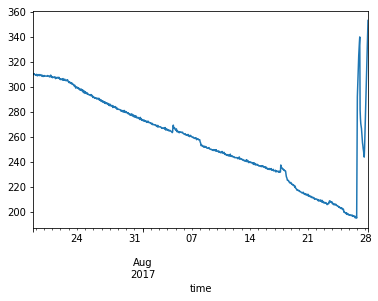

In [24]:
df['PINP'].plot()
plt.show()

In [ ]:
# I'm going to use this supposing it's good
RAseq = []
for i in RandSmplSeq(data, 600, 2000):
    x = ReverseArrangement(i,dirn=1)    
    if(len(x) == 21):
        RAseq.append(x)    
result_seq = np.vstack(RAseq)


In [3]:
ls ~/data/wells

10_346.h5  12_351.h5  12_356.h5  12_361.h5  12_366.h5  12_371.h5  12_376.h5
10_347.h5  12_352.h5  12_357.h5  12_362.h5  12_367.h5  12_372.h5  13_388.h5
11_348.h5  12_353.h5  12_358.h5  12_363.h5  12_368.h5  12_373.h5  1_1.h5
12_349.h5  12_354.h5  12_359.h5  12_364.h5  12_369.h5  12_374.h5  2_26.h5
12_350.h5  12_355.h5  12_360.h5  12_365.h5  12_370.h5  12_375.h5


In [11]:
   
    
    

# I'm going to use this supposing it's good
RAseq = []
for i in RandSmplSeq(data, 600, 2000):
    x = ReverseArrangement(i,dirn=1)    
    if(len(x) == 21):
        RAseq.append(x)    
result_noseq = np.vstack(RAseq)

# final 10-hours going to suppose that this was bad
smp = data.iloc[-60:]
x = ReverseArrangement(smp)
last = x*4/(60.*59)

# just fake it 'til we make it:
result_failed = []
for i in range(0, 100):
    result_failed.append(last + np.random.randn(21)*0.1)

# maybe these are good indicators of failure
PCAS = 9
PINP = 10

pcas = np.append([i[PCAS] for i in result_noseq], [i[PCAS] for i in result_failed])
pinp = np.append([i[PINP] for i in result_noseq], [i[PINP] for i in result_failed])

inputs = np.vstack((pcas, pinp)).T
klass = np.append(np.ones(result_noseq.shape[0]), -np.ones(len(result_failed)))


client_token = 'GTIUUZSJMPWEFPHYZRTAGRGLEOSMFTMDZKHEZFLHYVUNUSQK'

svc_parameters  = {'kernel': ['linear', 'rbf'], 'C': (0.5, 100)}

# we probably should have compact support 
svr = svm.SVC()

clf = SigOptSearchCV(svr, svc_parameters, cv=5,
                client_token=client_token, n_jobs=5, n_iter=20)

clf.fit(inputs, klass)

print(clf)



SigOptSearchCV(client_token=None, cv=5, cv_timeout=None, error_score='raise',
        estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
        fit_params=None, iid=True, n_iter=20, n_jobs=5, n_sug=1,
        opt_timeout=None,
        param_domains={'kernel': ['linear', 'rbf'], 'C': (0.5, 100)},
        pre_dispatch='2*n_jobs', refit=True, scoring=None,
        sigopt_connection=<sigopt.interface.Connection object at 0x7f5e28a9d350>,
        verbose=0)


In [13]:
test = np.array([clf.predict([[last[PCAS] + np.random.randn() * 0.1, last[PINP] + 
                                                 np.random.randn()]])[0] for i in range(0,100)])


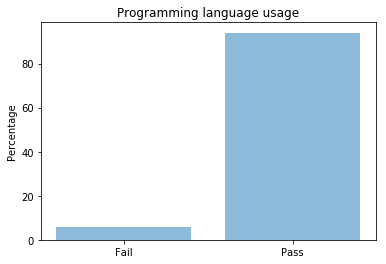

In [14]:
plt.bar([1,0], [np.sum(test < 0), np.sum(test>0)], align='center', alpha=0.5)
plt.xticks([1,0], ["Pass", "Fail"])
plt.ylabel('Percentage')
plt.show()